In [164]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

In [165]:
# FIXME: Code duplication
def is_valid_directory(finn_dir, verbose=False):
    group_name_file = finn_dir.parent / "group_name.txt"
    if not group_name_file.exists():
        if verbose:
            print(f"{group_name_file} does not exist")
        return False, None

    pred_ret_dir = finn_dir / "predicted_retardations"
    if not pred_ret_dir.exists() or not list(pred_ret_dir.iterdir()):
        if verbose:
            print(f"{pred_ret_dir} does not exist or is empty")
        return False, None

    try:
        c_train = np.load(finn_dir / "c_train.npy")
        c_predictions = np.load(finn_dir / "c_train_predictions.npy")
    except FileNotFoundError:
        if verbose:
            print(f"{finn_dir} does not contain c_train.npy or c_train_predictions.npy")
        return False, None
    if np.mean((c_train - c_predictions) ** 2) > 1e-4:
        if verbose:
            print(f"{finn_dir} has too large MSE for c")
        return False, None

    all_ret_file_paths = sorted(
        (finn_dir / "predicted_retardations").glob("retPred_*.npy"),
        key=lambda x: int(x.stem.split("_")[-1]),
    )
    epoch = int(all_ret_file_paths[-1].stem.split("_")[-1])
    if epoch < 100:
        if verbose:
            print(f"{finn_dir} has too few epochs")
        return False, None
    last_pred_ret = np.load(all_ret_file_paths[-1])
    if (
        np.isnan(last_pred_ret).any() or np.isinf(last_pred_ret).any()
        # or np.any((last_pred_ret < 3) | (last_pred_ret > 20))
    ):
        if verbose:
            print(f"{finn_dir}'s last predicted retardation is invalid")
        return False, None

    # is d^2fdx^2 almost zero?
    dx = 1 / 100
    dfdx = np.diff(last_pred_ret, axis=0) / dx
    dfdx2 = np.diff(dfdx, axis=0) / dx
    if np.all(np.abs(dfdx2) < 10):
        if verbose:
            print(f"{finn_dir}'s last predicted retardation is almost a straight line")
        return False, None

    return True, all_ret_file_paths[-1]


def collect_valid_simulation_dirs(root_dir, verbose=False):
    valid_dirs = []
    for ret_dir in root_dir.rglob("predicted_retardations"):
        finn_dir = ret_dir.parent
        is_dir_valid, learned_ret_file_path = is_valid_directory(
            finn_dir, verbose=verbose
        )
        if is_dir_valid:
            group_name = (finn_dir.parent / "group_name.txt").read_text().strip()
            valid_dirs.append((finn_dir, group_name, learned_ret_file_path))
    return valid_dirs


def compute_mse(a, b):
    return np.mean((a - b) ** 2)

In [166]:
# A) Collect all valid simulation directories
root_dir = Path("../data_out")
valid_finn_dirs = collect_valid_simulation_dirs(root_dir, verbose=True)

records = []
for finn_dir, group_name, learned_ret_file_path in valid_finn_dirs:
    records.append(
        {
            "finn_dir": finn_dir,
            "group_name": group_name,
            "exp_label": f"{group_name}_{finn_dir.name}",
            "learned_ret_file_path": learned_ret_file_path,
            "analytical_ret_type": "langmuir"
            if "langmuir" in str(finn_dir)
            else "freundlich",
        }
    )

finn_dir_df = pd.DataFrame.from_records(records)
print(len(finn_dir_df))
finn_dir_df.head()

../data_out/langmuir/finn_different_loss_patterns/844582151_finn_different_loss_patterns does not contain c_train.npy or c_train_predictions.npy
../data_out/langmuir/finn_different_loss_patterns/600702895_finn_different_loss_patterns does not contain c_train.npy or c_train_predictions.npy
../data_out/langmuir/group_name.txt does not exist
../data_out/langmuir/group_name.txt does not exist
../data_out/langmuir/finn_increasing_time/418657609_finn_increasing_time does not contain c_train.npy or c_train_predictions.npy
../data_out/langmuir/finn_increasing_time/568399616_finn_increasing_time does not contain c_train.npy or c_train_predictions.npy
../data_out/langmuir/finn_increasing_time/842601246_finn_increasing_time does not contain c_train.npy or c_train_predictions.npy
../data_out/langmuir/finn_increasing_time/524849115_finn_increasing_time does not contain c_train.npy or c_train_predictions.npy
../data_out/langmuir/finn_increasing_time/707058530_finn_increasing_time does not contain c_

,finn_dir,group_name,exp_label,learned_ret_file_path,analytical_ret_type
0,../data_out/langmuir/finn_different_loss_patte...,Loss Patterns,Loss Patterns_188560057_finn_different_loss_pa...,../data_out/langmuir/finn_different_loss_patte...,langmuir
1,../data_out/langmuir/finn_different_loss_patte...,Loss Patterns,Loss Patterns_250751246_finn_different_loss_pa...,../data_out/langmuir/finn_different_loss_patte...,langmuir
2,../data_out/langmuir/finn_different_loss_patte...,Loss Patterns,Loss Patterns_129439445_finn_different_loss_pa...,../data_out/langmuir/finn_different_loss_patte...,langmuir
3,../data_out/langmuir/finn_different_loss_patte...,Loss Patterns,Loss Patterns_597133418_finn_different_loss_pa...,../data_out/langmuir/finn_different_loss_patte...,langmuir
4,../data_out/langmuir/finn_different_loss_patte...,Loss Patterns,Loss Patterns_360066793_finn_different_loss_pa...,../data_out/langmuir/finn_different_loss_patte...,langmuir


In [167]:
# B) Compute MSE of c and ret for each simulation directory
mse_data = []
for _, row in finn_dir_df.iterrows():
    finn_dir = row["finn_dir"]
    c_full = np.load(finn_dir / "c_full.npy")
    c_train = np.load(finn_dir / "c_train.npy")
    c_train_predictions = np.load(finn_dir / "c_train_predictions.npy")
    c_full_predictions = np.load(finn_dir / "c_full_predictions.npy")
    # u_ret = np.load(finn_dir / "u_ret.npy")
    last_pred_ret = np.load(row["learned_ret_file_path"])
    analytical_ret = np.load(finn_dir / f"retardation_{row['analytical_ret_type']}.npy")

    mse_c_train = compute_mse(c_train, c_train_predictions)
    mse_c_full = compute_mse(c_full, c_full_predictions)
    mse_ret = compute_mse(analytical_ret, last_pred_ret)

    mse_data.append(
        {
            "exp_label": row["exp_label"],
            "mse_c_train": mse_c_train,
            "mse_c_full": mse_c_full,
            "mse_ret": mse_ret,
        }
    )

mse_df = pd.DataFrame(mse_data)
mse_df.head()

,exp_label,mse_c_train,mse_c_full,mse_ret
0,Loss Patterns_188560057_finn_different_loss_pa...,1.314478e-07,0.000001,0.000828
1,Loss Patterns_250751246_finn_different_loss_pa...,1.328082e-07,0.000001,0.000814
2,Loss Patterns_129439445_finn_different_loss_pa...,1.439413e-07,0.000002,0.000952
3,Loss Patterns_597133418_finn_different_loss_pa...,1.327184e-07,0.000001,0.000833
4,Loss Patterns_360066793_finn_different_loss_pa...,1.315785e-07,0.000001,0.000867


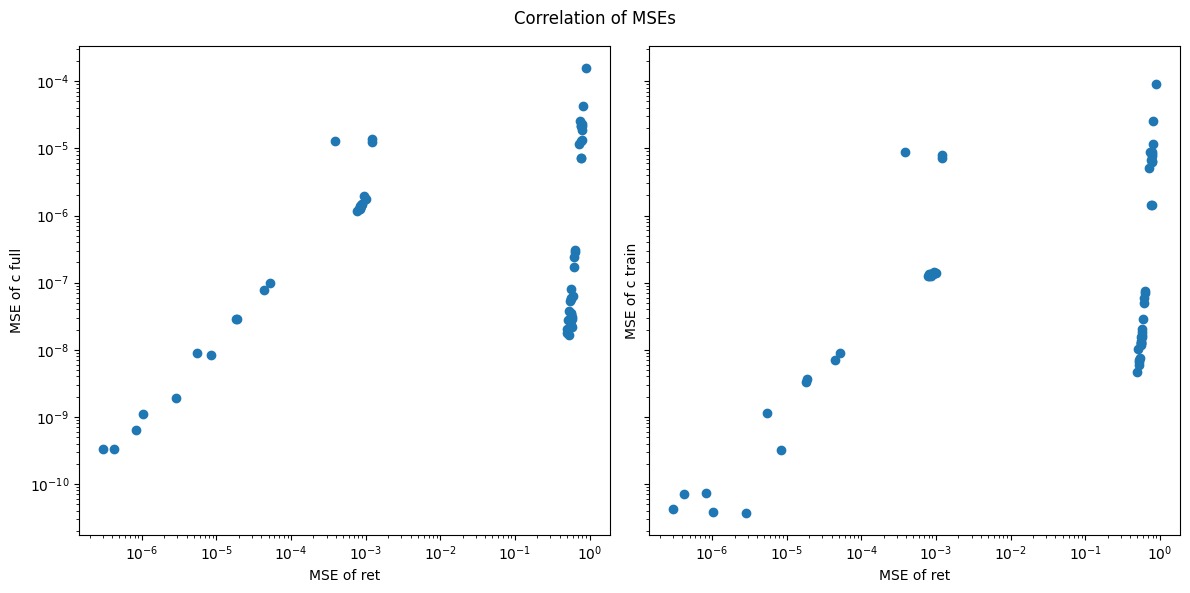

In [168]:
# Plot correlation of MSEs
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6), sharey=True)
fig.suptitle("Correlation of MSEs")

ax1.scatter(mse_df["mse_ret"], mse_df["mse_c_full"])
ax2.scatter(mse_df["mse_ret"], mse_df["mse_c_train"])
for ax in (ax1, ax2):
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel("MSE of ret")
ax1.set_ylabel("MSE of c full")
ax2.set_ylabel("MSE of c train")

plt.tight_layout()
plt.show()

In [169]:
# C) Plot final retardations of each simulation directory
ret_df = finn_dir_df.copy()
ret_df["ret"] = finn_dir_df["learned_ret_file_path"].apply(lambda p: np.load(p).ravel())
ret_df = ret_df.explode("ret").reset_index(drop=True)
ret_df["u"] = np.tile(np.arange(0, 100), len(finn_dir_df))
ret_df["ret"] = ret_df["ret"].astype(np.float64)

In [170]:
ret_df

,finn_dir,group_name,exp_label,learned_ret_file_path,analytical_ret_type,ret,u
0,../data_out/langmuir/finn_different_loss_patte...,Loss Patterns,Loss Patterns_188560057_finn_different_loss_pa...,../data_out/langmuir/finn_different_loss_patte...,langmuir,5.069542,0
1,../data_out/langmuir/finn_different_loss_patte...,Loss Patterns,Loss Patterns_188560057_finn_different_loss_pa...,../data_out/langmuir/finn_different_loss_patte...,langmuir,5.000842,1
2,../data_out/langmuir/finn_different_loss_patte...,Loss Patterns,Loss Patterns_188560057_finn_different_loss_pa...,../data_out/langmuir/finn_different_loss_patte...,langmuir,4.933151,2
3,../data_out/langmuir/finn_different_loss_patte...,Loss Patterns,Loss Patterns_188560057_finn_different_loss_pa...,../data_out/langmuir/finn_different_loss_patte...,langmuir,4.866478,3
4,../data_out/langmuir/finn_different_loss_patte...,Loss Patterns,Loss Patterns_188560057_finn_different_loss_pa...,../data_out/langmuir/finn_different_loss_patte...,langmuir,4.800827,4
...,...,...,...,...,...,...,...
6095,../data_out/freundlich/finn_all_UQ_factors/462...,All UQ,All UQ_462987949_cFullNoise_sigma=0.001_j=15_f...,../data_out/freundlich/finn_all_UQ_factors/462...,freundlich,3.134637,95
6096,../data_out/freundlich/finn_all_UQ_factors/462...,All UQ,All UQ_462987949_cFullNoise_sigma=0.001_j=15_f...,../data_out/freundlich/finn_all_UQ_factors/462...,freundlich,3.131493,96
6097,../data_out/freundlich/finn_all_UQ_factors/462...,All UQ,All UQ_462987949_cFullNoise_sigma=0.001_j=15_f...,../data_out/freundlich/finn_all_UQ_factors/462...,freundlich,3.128423,97
6098,../data_out/freundlich/finn_all_UQ_factors/462...,All UQ,All UQ_462987949_cFullNoise_sigma=0.001_j=15_f...,../data_out/freundlich/finn_all_UQ_factors/462...,freundlich,3.125427,98


In [171]:
analytical_rets = {
    x: np.load(finn_dir_df.iloc[0]["finn_dir"] / f"retardation_{x}.npy")
    for x in ["freundlich", "langmuir", "linear"]
}

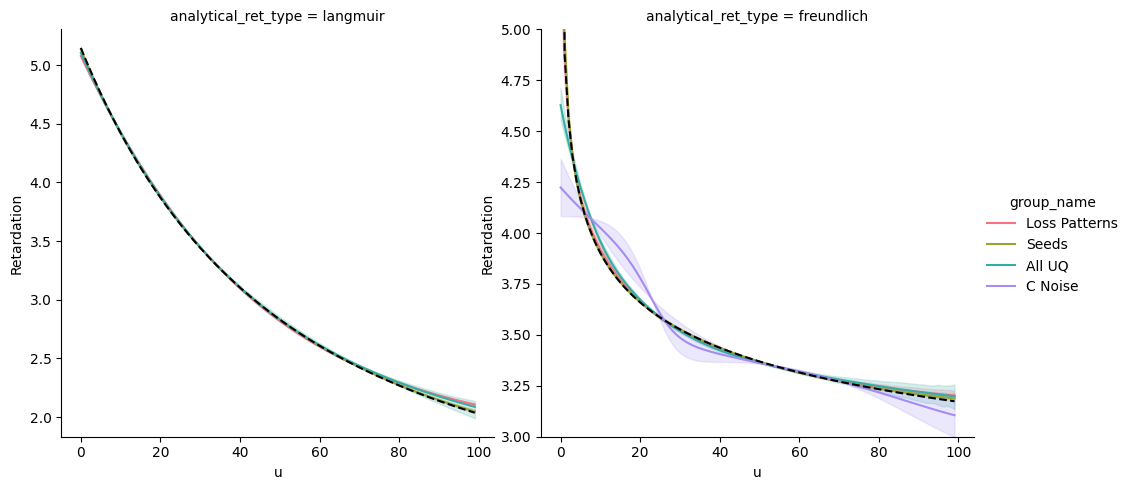

In [172]:
g = sns.relplot(
    data=ret_df,
    kind="line",
    x="u",
    y="ret",
    hue="group_name",
    col="analytical_ret_type",
    # style="group_name",
    # markers=True,
    # dashes=False,
    # legend="brief",
    palette=sns.color_palette("husl", len(finn_dir_df["group_name"].unique())),
    facet_kws={"sharey": False},
)

for analytical_retardation_type, ax in g.axes_dict.items():
    ax.plot(
        analytical_rets[analytical_retardation_type],
        "k--",
        label=analytical_retardation_type.capitalize(),
    )
    if analytical_retardation_type.lower() == "freundlich":
        ax.set_ylim(3, 5)
    ax.set_xlabel("u")
    ax.set_ylabel("Retardation")

plt.show()

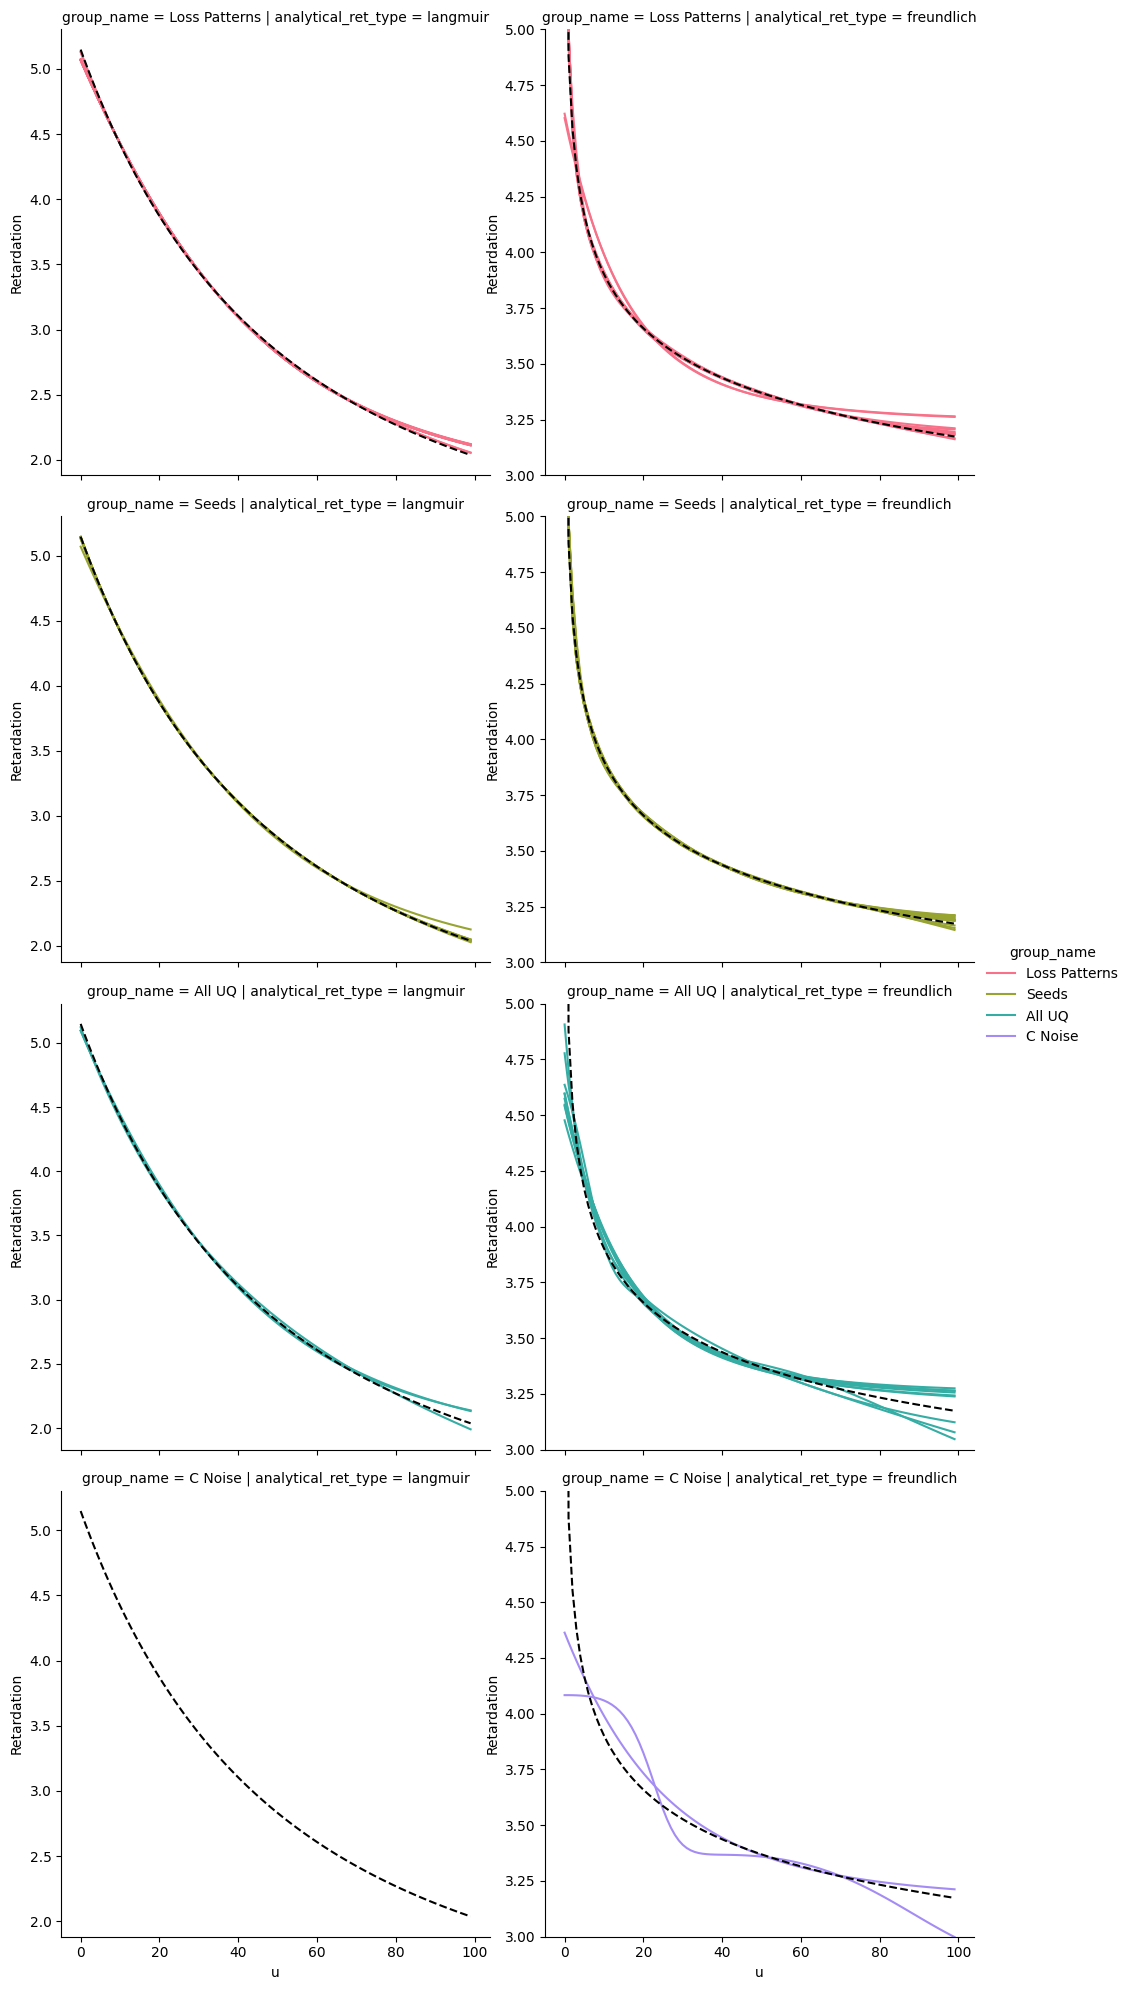

In [173]:
g = sns.relplot(
    data=ret_df,
    kind="line",
    x="u",
    y="ret",
    hue="group_name",
    row="group_name",
    col="analytical_ret_type",
    units="exp_label",
    estimator=None,
    palette=sns.color_palette("husl", len(finn_dir_df["group_name"].unique())),
    facet_kws={"sharey": False},
)

for (_, analytical_retardation_type), ax in g.axes_dict.items():
    ax.plot(
        analytical_rets[analytical_retardation_type],
        "k--",
        label=analytical_retardation_type.capitalize(),
    )
    if analytical_retardation_type.lower() == "freundlich":
        ax.set_ylim(3, 5)
    ax.set_xlabel("u")
    ax.set_ylabel("Retardation")

plt.show()

In [189]:
# D) Compute enclosing (upper and lower) curves for each group
grouped_ret = ret_df.groupby(["group_name", "analytical_ret_type"])

enclosing_curves = []
for group_tuple, group in grouped_ret:
    group_ret = group.pivot(index="u", columns="exp_label", values="ret").values
    lower_curve = np.min(group_ret, axis=1)
    upper_curve = np.max(group_ret, axis=1)
    enclosing_curves.append(
        {
            "group_name": group_tuple[0],
            "analytical_ret_type": group_tuple[1],
            "lower_curve": lower_curve.astype(float),
            "upper_curve": upper_curve.astype(float),
            "u": np.linspace(0, 1, len(lower_curve)),
        }
    )

enclosing_df = pd.DataFrame(enclosing_curves)
enclosing_df = enclosing_df.explode(["lower_curve", "upper_curve", "u"]).reset_index()
enclosing_df

,index,group_name,analytical_ret_type,lower_curve,upper_curve,u
0,0,All UQ,freundlich,4.476705,4.906657,0.0
1,0,All UQ,freundlich,4.413525,4.703079,0.010101
2,0,All UQ,freundlich,4.35358,4.540097,0.020202
3,0,All UQ,freundlich,4.296749,4.444453,0.030303
4,0,All UQ,freundlich,4.2429,4.368184,0.040404
...,...,...,...,...,...,...
695,6,Seeds,langmuir,2.071881,2.15475,0.959596
696,6,Seeds,langmuir,2.060275,2.146882,0.969697
697,6,Seeds,langmuir,2.048821,2.139202,0.979798
698,6,Seeds,langmuir,2.037518,2.131705,0.989899


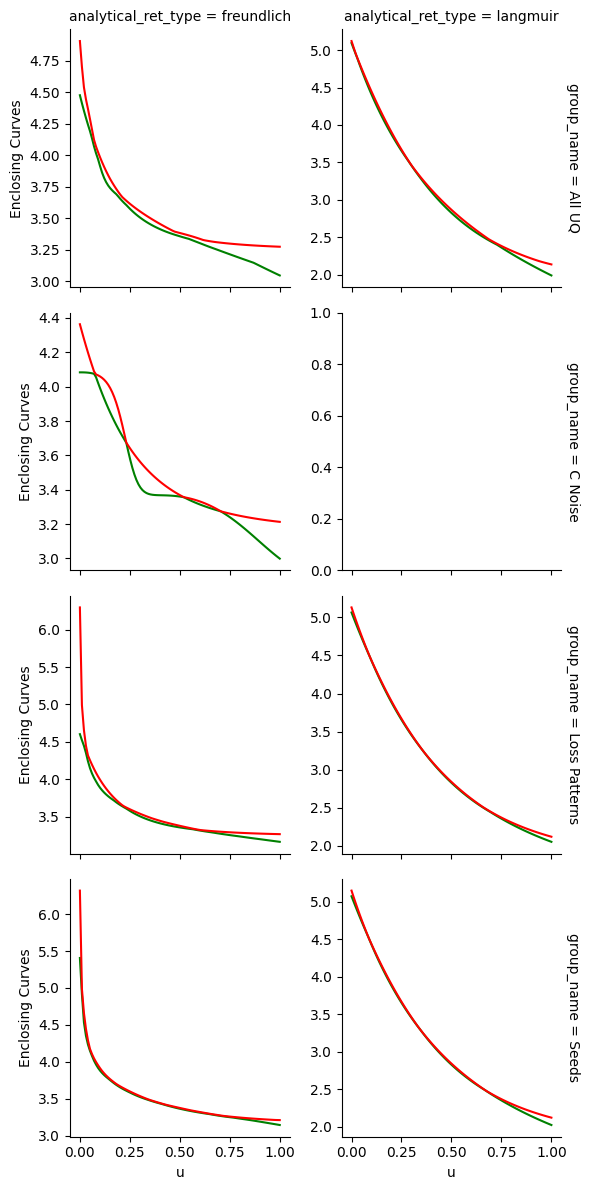

In [199]:
def plot_enclosing(x, y, *args, **kwargs):
    plt.plot(x, y, *args, **kwargs)


g = sns.FacetGrid(
    data=enclosing_df,
    row="group_name",
    col="analytical_ret_type",
    margin_titles=True,
    sharey=False,
)

g.map(plot_enclosing, "u", "lower_curve", color="green")
g.map(plot_enclosing, "u", "upper_curve", color="red")

for ax, row_val in zip(g.axes[:, 0], g.row_names):
    ax.set_ylabel("Enclosing Curves")
    # ax.annotate(row_val, xy=(0, 0.5), xycoords="axes fraction", ha="right", va="center", fontsize=12, rotation=90)

plt.show()

plt.show()

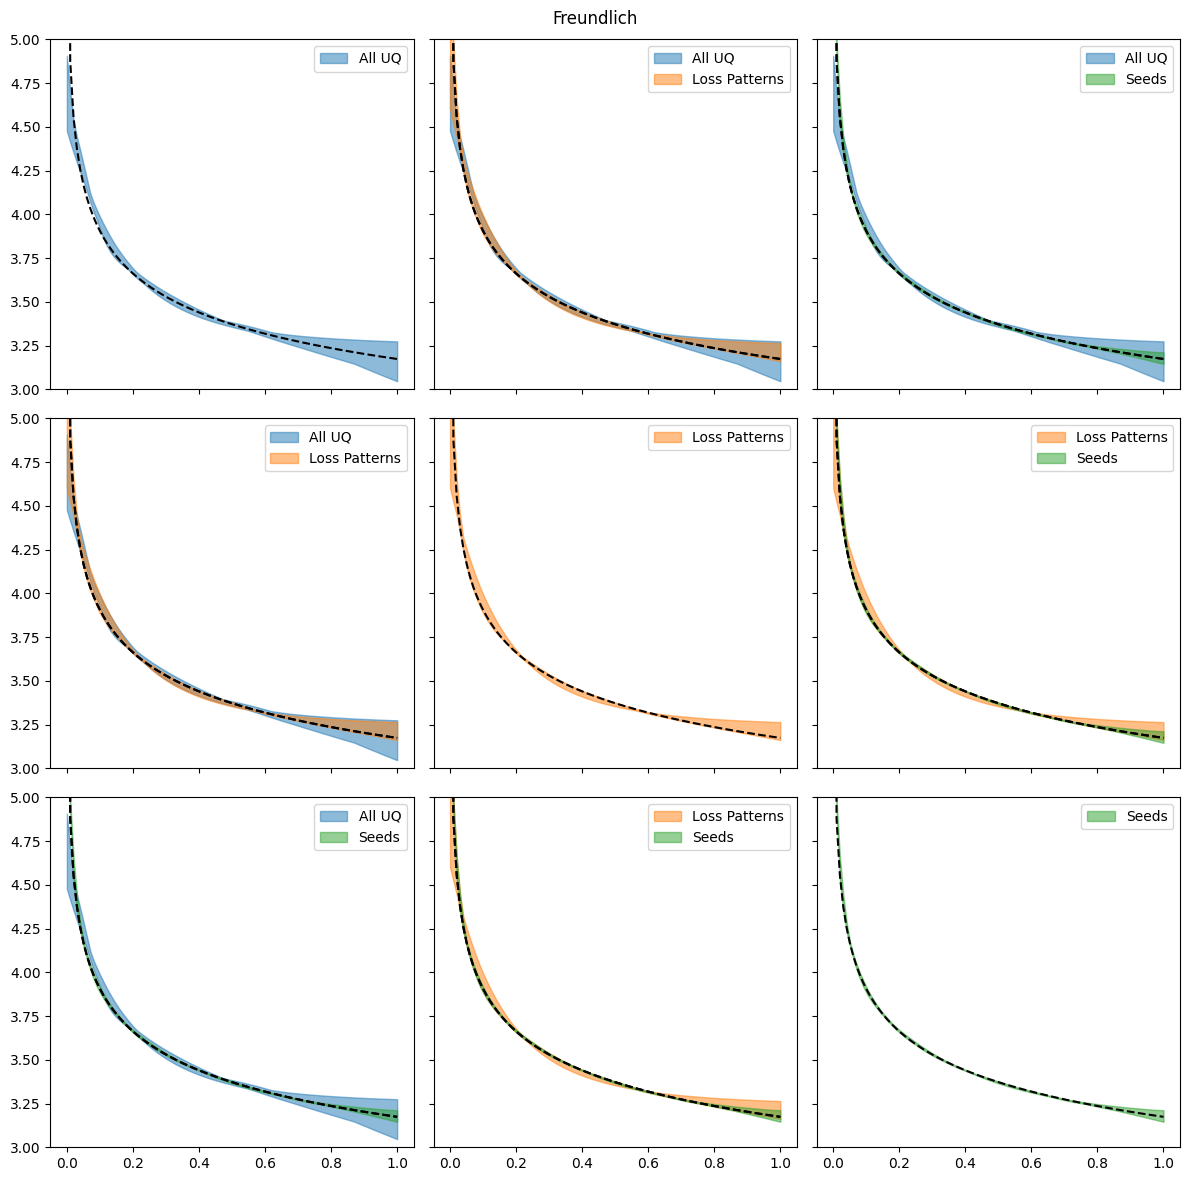

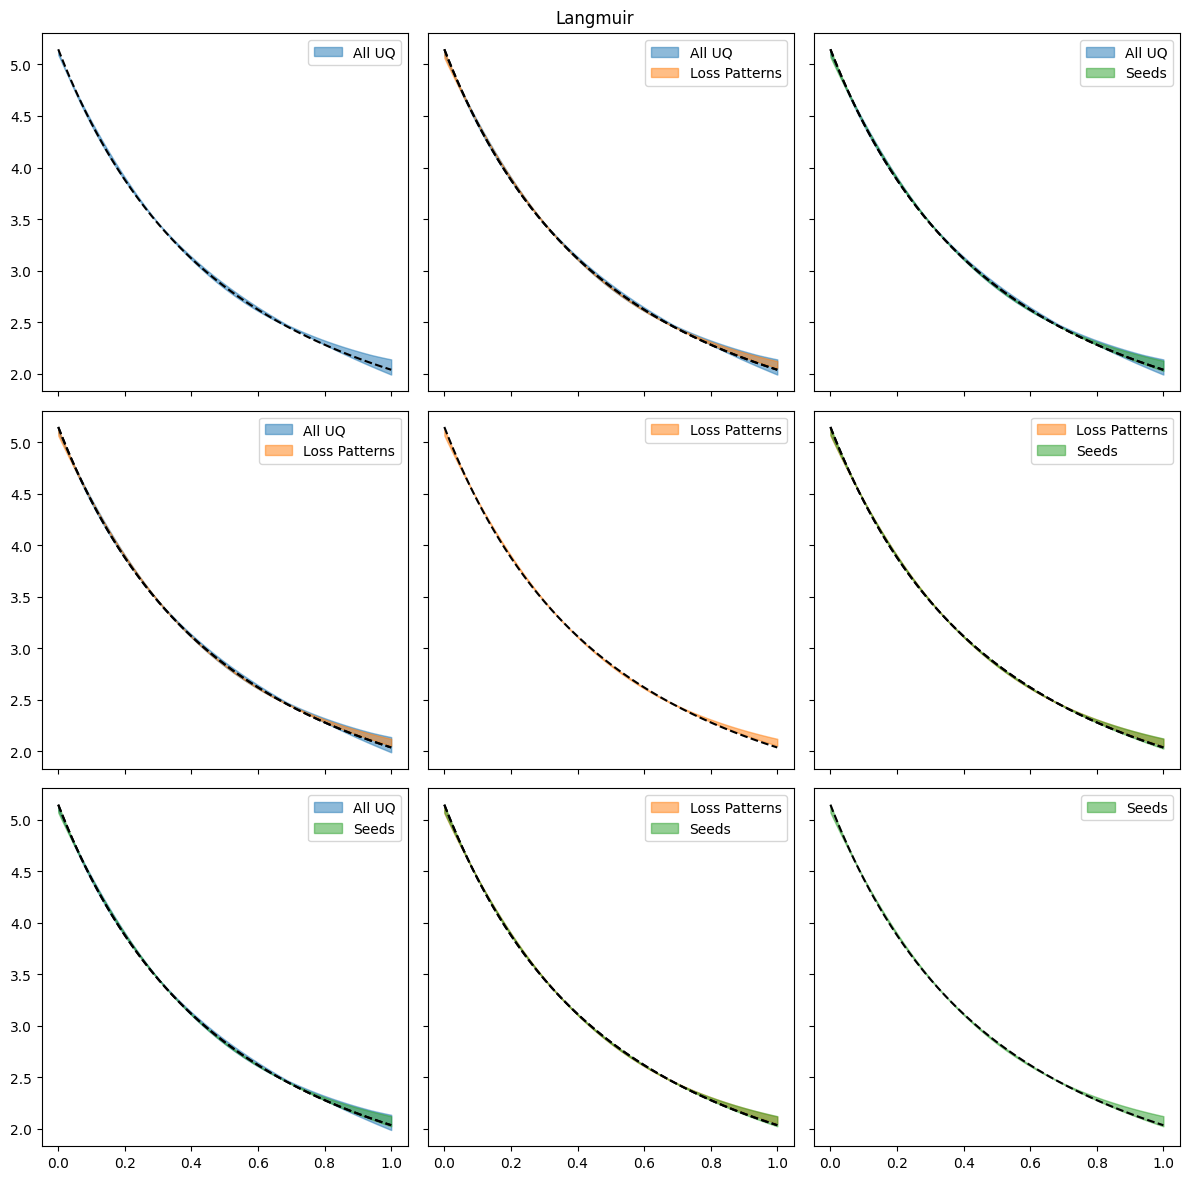

In [207]:
ALPHA_ENVELOPES = 0.5
ALPHA_CURVES = 0.3


# %% Compute and plot enclosing curves
def pair_plots(ret_df):
    ret_df_groups = ret_df.groupby(["group_name", "analytical_ret_type"])
    num_groups = len(ret_df_groups)
    fig, axes = plt.subplots(
        num_groups,
        num_groups,
        figsize=(4 * num_groups, 4 * num_groups),
        sharex=True,
        sharey=True,
    )

    for i, (group_labels, sub_ret_df) in enumerate(ret_df_groups):
        # ax = axes[i, j]
        # if i <= j:
        #     fig.delaxes(ax)  # Hide empty axes
        #     continue

        color = f"C{i}"

        analytical_retardation_type = group_labels[1]
        analytical_ret = analytical_rets[analytical_retardation_type]
        u = np.linspace(0, 1, analytical_ret.size)

        # Plot single curves
        # for exp_label in finn_dir_df[finn_dir_df["group_name"] == group1]["exp_label"]:
        #     ret = ret_df[ret_df["exp_label"] == exp_label]["ret"].values
        #     ax.plot(u, ret, color=color1, alpha=ALPHA_CURVES)
        # for exp_label in finn_dir_df[finn_dir_df["group_name"] == group2]["exp_label"]:
        #     ret = ret_df[ret_df["exp_label"] == exp_label]["ret"].values
        #     ax.plot(u, ret, color=color2, alpha=ALPHA_CURVES)

        # Compute and plot enclosing curves
        all_rets = sub_ret_df["ret"].to_numpy().reshape(-1, analytical_ret.shape[0])
        min_curve = np.min(all_rets, axis=0)
        max_curve = np.max(all_rets, axis=0)

        def plot_all(ax):
            ax.fill_between(
                x=u,
                y1=min_curve,
                y2=max_curve,
                color=color,
                alpha=ALPHA_ENVELOPES,
                label=group_labels[0],
            )

            # Plot enveloping curves
            # ax.plot(u, min_curve1, color=color1, linewidth=2)
            # ax.plot(u, max_curve1, color=color1, linewidth=2)
            # ax.plot(u, min_curve2, color=color2, linewidth=2)
            # ax.plot(u, max_curve2, color=color2, linewidth=2)

            if analytical_retardation_type == "freundlich":
                ax.set_ylim(3, 5)

            ax.plot(u, analytical_ret, "k--")  # , label="Analytical Retardation")

            ax.legend()

        for k in range(num_groups):
            row = i
            col = k
            plot_all(axes[row, col])

        for k in range(num_groups):
            row = k
            col = i
            if row == col:
                continue
            plot_all(axes[row, col])

    # for ax in axes.flat:

    plt.tight_layout()


# skip C Noise here because the convergence criterion is not valid for it (because added noise will always be larger then the MSE cutoff)
for analytical_ret_type, sub_df in ret_df[ret_df["group_name"] != "C Noise"].groupby("analytical_ret_type"):
    pair_plots(sub_df)
    plt.gcf().suptitle(analytical_ret_type.capitalize())
    plt.tight_layout()


plt.show()

# Sample Points between Curves for PI3NN

ValueError: zero-size array to reduction operation maximum which has no identity

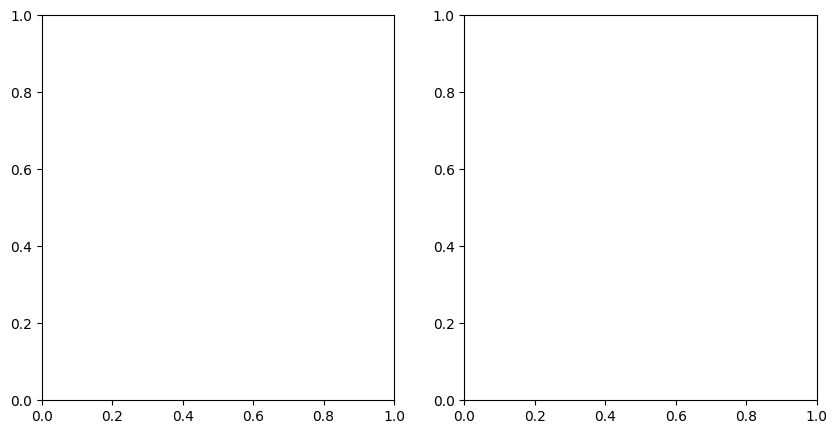

In [177]:
from common import is_below_curve, is_above_curve

fig, axs = plt.subplots(1, len(groups), figsize=(5 * len(groups), 5))

group_envelope_points = {}

for i, group1 in enumerate(groups):
    u = np.linspace(0, 1, analytical_ret.size)

    # Compute enclosing curves
    ret_group = np.asarray(
        ret_df[ret_df["group_name"] == group1]["ret"].values.reshape(
            -1, analytical_ret.size
        )
    )
    envelope_curve_up = np.max(ret_group, axis=0)
    envelope_curve_down = np.min(ret_group, axis=0)

    # Sample points
    y_max = envelope_curve_up.max()
    y_min = envelope_curve_down.min()

    rng = np.random.default_rng(2864343564)
    rectangle_points = rng.uniform(low=0, high=1, size=(10**5, 2))
    rectangle_points[:, 1] = rectangle_points[:, 1] * (y_max - y_min) + y_min

    is_below = is_below_curve(u, envelope_curve_up, rectangle_points)
    is_above = is_above_curve(u, envelope_curve_down, rectangle_points)
    is_between = is_below * is_above

    envelope_points = rectangle_points[is_between].copy()
    group_envelope_points[group1] = envelope_points

    # Plot sampled points
    print(f"{len(envelope_points)} are between for {group1}")
    u = np.linspace(0, 1, len(envelope_curve_up))
    axs[i].plot(*envelope_points[:200].T, ".")
    axs[i].plot(u, envelope_curve_up, "g-", lw=0.9)
    axs[i].plot(u, envelope_curve_down, "r-", lw=0.9)
    axs[i].set_title(group1)

plt.show()

In [ ]:
# Save envelope points
for group, envelope_points in group_envelope_points.items():
    assert len(envelope_points) >= 500
    pinn_base_path = Path("../data_out/3pinn").resolve()
    pinn_dir = pinn_base_path / f"{group.replace(' ', '_')}"
    pinn_dir.mkdir(exist_ok=True, parents=True)
    pinn_x_path = pinn_dir / "x.npy"
    pinn_y_path = pinn_dir / "y.npy"

    np.save(pinn_x_path, envelope_points[:500, 0])
    np.save(pinn_y_path, envelope_points[:500, 1])